# Spiętrzony dwukierunkowy klasyfikator LSTM nastroju

Ten notatnik implementuje *spiętrzoną* sieć LSTM do klasyfikowania nastroju recencji filmów z bazy IMDb.

#### Załadowanie zależności.


In [ ]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from keras.layers.wrappers import Bidirectional 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


#### Ustawienie hiperparametrów.


In [ ]:
# Nazwa katalogu wyjściowego:
output_dir = 'model_output/stackedLSTM'

# Trening:
epochs = 4
batch_size = 128

# Osadzanie wektorów słów:
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# Architektura warstwy LSTM:
n_lstm_1 = 64 # lower
n_lstm_2 = 64 # new!
drop_lstm = 0.2

#### Załadowanie danych.


In [ ]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

#### Wstępne przetworzenie danych.


In [ ]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Architektura sieci neuronowej.


In [ ]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Bidirectional(LSTM(n_lstm_1, dropout=drop_lstm, 
                             return_sequences=True))) 
model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Liczba parametrów warstwy LSTM jest dwukrotnie większa, ponieważ odczytywanie jest dwukierunkowe.
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 804,993
Trainable params: 804,993
Non-trainable params: 0
_________________________________________________________________


#### Konfiguracja modelu.


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Trening!


In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 98s 4ms/step - loss: 0.4332 - acc: 0.7819 - val_loss: 0.3230 - val_acc: 0.8644
Epoch 2/4
25000/25000 [==============================] - 94s 4ms/step - loss: 0.2466 - acc: 0.9030 - val_loss: 0.2957 - val_acc: 0.8783
Epoch 3/4
25000/25000 [==============================] - 94s 4ms/step - loss: 0.1851 - acc: 0.9292 - val_loss: 0.3258 - val_acc: 0.8681
Epoch 4/4
25000/25000 [==============================] - 94s 4ms/step - loss: 0.1462 - acc: 0.9462 - val_loss: 0.3479 - val_acc: 0.8695


#### Ocena.

In [ ]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [ ]:
y_hat = model.predict_proba(x_valid)

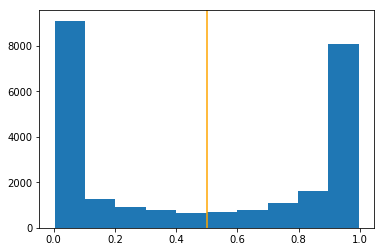

In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.87'